# Analysis of Data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import xgboost as xgb
import lightgbm as lgb



In [12]:
df = pd.read_csv("/Users/callum/Work/Projects/Student_Depression_Analysis/Student Depression Dataset.csv")


In [13]:
df.head(5)

#print(set(df["City"]))
#print(set(df["Profession"]))
#print(set(df["Sleep Duration"]))
#print(set(df["Dietary Habits"]))

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


Finding Anomalies in Data

In [14]:
# Check for missing values
missing_values = df.isnull()

# Display the count of missing values per column
missing_count = missing_values.sum()

# Show the locations of missing values (True indicates missing value)
print("Missing values per column:")
print(missing_count)

# Drop missing values
df = df.dropna()

# Check for missing values
missing_values = df.isnull()

# Display the count of missing values per column
missing_count = missing_values.sum()

# Show the locations of missing values (True indicates missing value)
print("Missing values per column:")
print(missing_count)


Missing values per column:
id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64
Missing values per column:
id                                       0
Gender                                   0
Age                                      0
City                          

Clean Data

In [15]:
# replace string binary variables with numerical binary values
df['Gender'] = np.where(df['Gender'] == "Male", 0, 1)
df['Have you ever had suicidal thoughts ?'] = np.where(df['Have you ever had suicidal thoughts ?'] == "No", 0, 1)
df['Family History of Mental Illness'] = np.where(df['Family History of Mental Illness'] == "No", 0, 1)


# convert categorical ordinal variables to numerical
hours_sleep_mapping = {'Others':0, 'Less than 5 hours': 1, '5-6 hours': 2, '7-8 hours': 3, 'More than 8 hours': 4}
Dietary_Habits= {'Others':0, 'Unhealthy': 1, 'Moderate': 2, 'Healthy': 3}

df['Sleep Duration'] = df['Sleep Duration'].map(hours_sleep_mapping)
df['Dietary Habits'] = df['Dietary Habits'].map(Dietary_Habits)


# List of columns to exclude
exclude_columns = ['City', 'Profession', 'Degree']

# Select all columns except those in the exclude list
df_filtered = df.drop(columns=exclude_columns)

df_matrix = pd.DataFrame(df_filtered)

Data Diagnostics

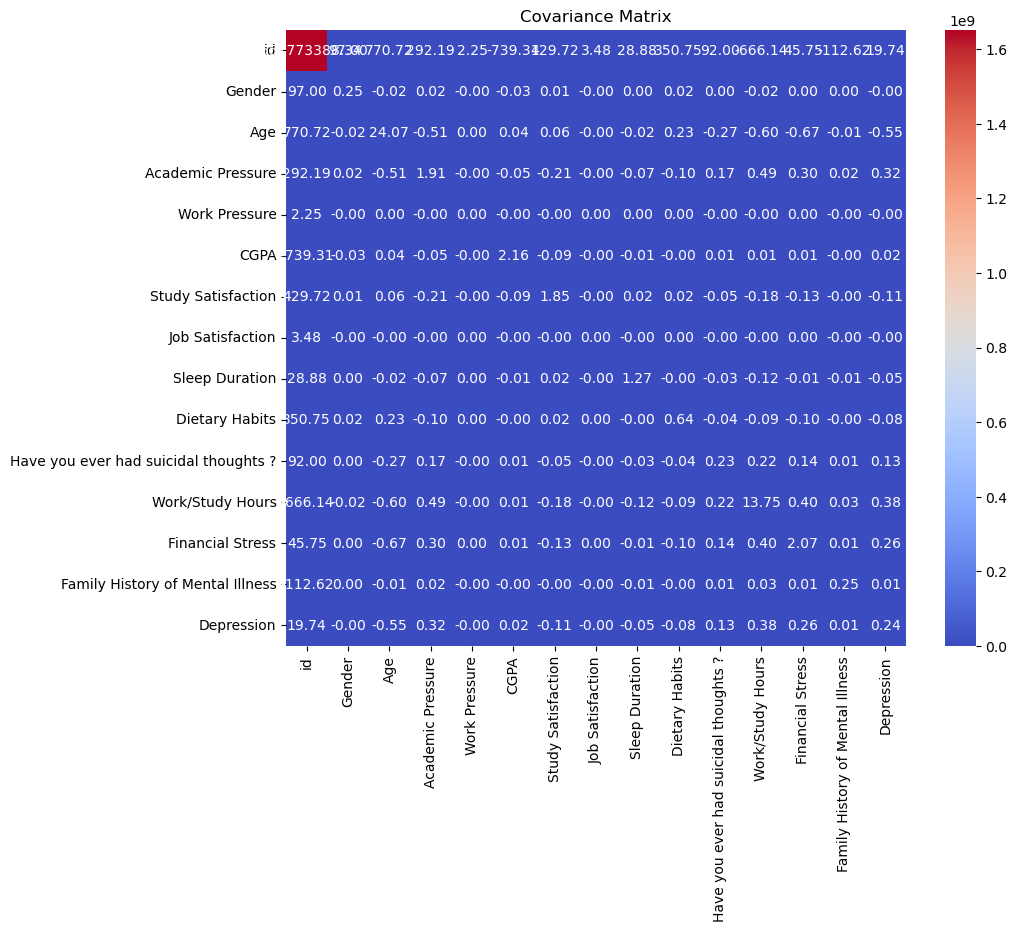

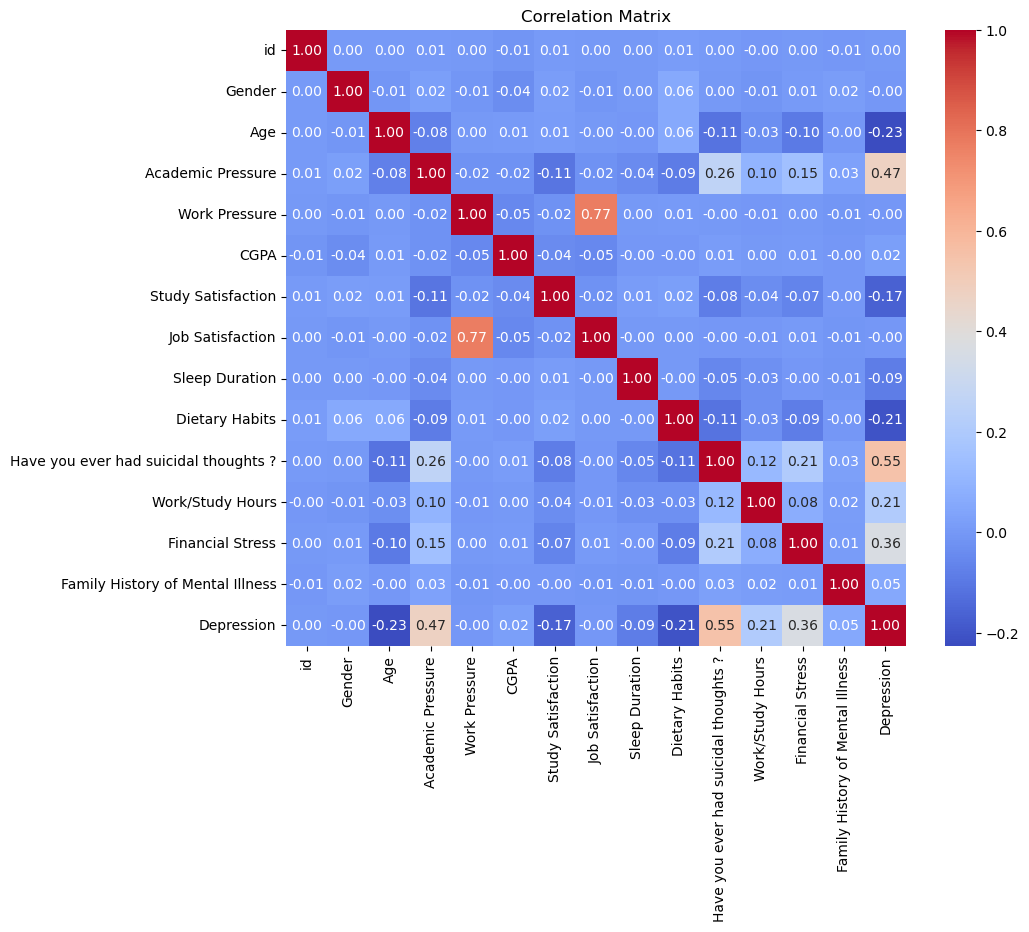

In [16]:

# Compute the covariance matrix
cov_matrix = df_matrix.cov()

# Compute the correlation matrix
corr_matrix = df_matrix.corr()

# Create the covariance heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Covariance Matrix')
plt.show()

# Create the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()

Split Data into Training and Validation data

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y)
X = df_matrix  # Features (independent variables)
X = X.drop(columns=['Depression'])
y = df_matrix['Depression']  # Target (dependent variable)


# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the results
print("Training Features (X_train):")
print(X_train)
print("\nValidation Features (X_val):")
print(X_val)


Training Features (X_train):
           id  Gender   Age  Academic Pressure  Work Pressure  CGPA  \
26049  131266       0  34.0                2.0            0.0  8.17   
20528  103926       0  23.0                5.0            0.0  5.74   
15399   77678       1  25.0                3.0            0.0  9.63   
15001   75634       1  20.0                1.0            0.0  5.57   
24417  122983       1  30.0                0.0            0.0  5.47   
...       ...     ...   ...                ...            ...   ...   
21578  108960       1  25.0                2.0            0.0  5.74   
5391    27206       0  23.0                5.0            0.0  5.32   
860      4417       0  18.0                5.0            0.0  6.37   
15797   79878       0  29.0                2.0            0.0  8.81   
23657  119213       1  23.0                2.0            0.0  5.79   

       Study Satisfaction  Job Satisfaction  Sleep Duration  Dietary Habits  \
26049                 4.0              

Cross Parameter Training with XGboost

In [18]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV



model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# Define the hyperparameters grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',  # You can use 'roc_auc', 'f1', etc.
                           cv=6,
                           verbose=1,
                           refit=True
                           )

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best hyperparameters:", grid_search.best_params_)

# Print the best score
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 6 folds for each of 81 candidates, totalling 486 fits


KeyboardInterrupt: 

Evaluating XGBoost Performance on Validation Data

In [ ]:

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_val)

from sklearn.metrics import accuracy_score

# Assuming you are doing classification
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')


NameError: name 'grid_search' is not defined

Evaluating Importance of Variables in Xgboost

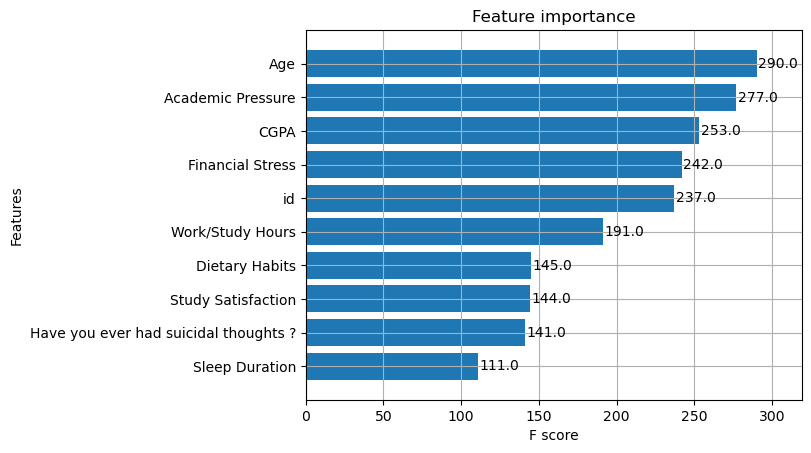

In [ ]:
# Get feature importance (using 'weight', 'gain', or 'cover')
importance = best_model.get_booster().get_score(importance_type='weight')

# Convert importance into a pandas DataFrame for better readability
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])

# Sort by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#plot results
xgb.plot_importance(best_model.get_booster(), importance_type='weight', max_num_features=10, height=0.8)
plt.show()


Adding Features to Exploit Important Variables

In [ ]:

# Define the bins (intervals) for categorizing the age
bins = [0, 25, 50, 75, 125]

# Define the labels for the categories
labels = ["0-24", "25-49", "50-74", "75+"]

# Create a pandas DataFrame or Series for categorizing the ages
df_filtered["Age_cat"] = pd.cut(df_filtered["Age"], bins=bins, labels=labels, right=False)

df_filtered["Age_cat"] = df_filtered["Age_cat"].map({"0-24":1,"25-49":2,"50-74":3,"75+":4 })

df_filtered["Age_cat"].head()


In [ ]:
# creating an over_40 filter that distinguishes between young and older respondents
df_filtered["Over_40"] = np.where(df_filtered["Age"] > 40, 1, 0)
#df_new = df_filtered.drop("Age_cat",axis=1)



Rerun Algorithm with New Variables

In [ ]:
df_new_var_matrix = pd.DataFrame(df_filtered)
X = df_new_var_matrix  # Features (independent variables)
X = X.drop(columns=['Depression'])
y = df_new_var_matrix['Depression']  # Target (dependent variable)

# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

new_var_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=300, random_state=42,
                                  learning_rate = 0.05, max_depth = 3, subsample= 0.7)

new_var_model.fit(X_train, y_train)

predictions = new_var_model.predict(X_val)

# Assuming you are doing classification
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8478494623655914


Training with SVM

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

#Standardize features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Define the parameter grid for SVM hyperparameters
# You can customize the grid based on your dataset and needs
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel types
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf'
    'degree': [3, 4],  # Degree for polynomial kernel (if used)
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)


# Get the best parameters and the corresponding model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the model on the test data
y_pred = best_model.predict(X_val)

# Print classification report and accuracy
# print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy on Test Set:", accuracy_score(y_val, y_pred))


# # Print the best parameters found
# print("Best hyperparameters:", grid_search.best_params_)

# # Print the best score
# print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy on Test Set: 0.8444444444444444


In [ ]:
# Evaluate the model on the test data
y_pred = best_model.predict(X_val)

# Print classification report and accuracy
# print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy on Test Set:", accuracy_score(y_val, y_pred))

# Evaluate the model on the test data
# y_pred = best_model.predict(X_test)

# Print classification report and accuracy
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))

Accuracy on Test Set: 0.8444444444444444


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the hyperparameters grid
param_grid = {
    'max_depth': [10, 20, 30],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',  # You can use 'roc_auc', 'f1', etc.
                           cv=6,
                           verbose=1,
                           refit=True
                           )

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best hyperparameters:", grid_search.best_params_)

# Print the best score
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 6 folds for each of 81 candidates, totalling 486 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8440277741636718


In [ ]:
#Evaluate the model on the test data
y_pred = best_model.predict(X_val)

#Print classification report and accuracy
print("Accuracy on Test Set:", accuracy_score(y_val, y_pred))

# Evaluate the model on the test data
# y_pred = best_model.predict(X_test)

# Print classification report and accuracy
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))